## Library import + training function 

In [36]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from scipy.sparse.linalg import eigsh
from scipy.stats import norm
from sklearn.model_selection import train_test_split


def training(denoiser, 
             samples, 
             num_epochs=200, 
             criterion = nn.MSELoss(), 
             lr=1e-3, 
             weight_decay=1e-4,
             alpha_max = np.pi/2):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(denoiser.parameters(), lr=lr, weight_decay=weight_decay)

    batch_size = 50
    device = torch.device("cpu")

    best_val_loss = float('inf')
    best_model_state = None
    true_loss = 0

    samples_train, samples_val = train_test_split(samples, test_size=0.4, random_state=42)
    train_tensor = torch.tensor(samples_train, dtype=torch.float32)
    val_tensor = torch.tensor(samples_val, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(train_tensor, train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_tensor, val_tensor), batch_size=5, shuffle=False)

    for epoch in range(num_epochs):
        denoiser.train()
        running_loss = 0.0

        for batch_X, _ in train_loader:
            batch_X = batch_X.to(device)
            optimizer.zero_grad()

            alpha_vals = np.random.uniform(0, alpha_max, size=(batch_X.shape[0],))
            alpha = torch.tensor(alpha_vals, dtype=torch.float32, device=device).unsqueeze(1)
            t = torch.tan(alpha).pow(2)

            noise = torch.randn_like(batch_X)
            input = (t * batch_X + t.sqrt() * noise)
            target = batch_X

            output = denoiser(input, alpha.squeeze(1))
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(denoiser.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # === VALIDATION ===
        denoiser.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch_X, _ in val_loader:
                batch_X = batch_X.to(device)

                alpha_vals = np.random.uniform(0, alpha_max, size=(batch_X.shape[0],))
                alpha = torch.tensor(alpha_vals, dtype=torch.float32, device=device).unsqueeze(1)
                t = torch.tan(alpha).pow(2)

                noise = torch.randn_like(batch_X)
                input = (t * batch_X + t.sqrt() * noise)
                target = batch_X

                output = denoiser(input, alpha.squeeze(1))

                # Empirical relative error
                rel_mse = (((output - target) ** 2).sum(dim=1) / (target ** 2).sum(dim=1).clamp(min=1e-8)).sqrt()
                val_loss += rel_mse.mean().item()


        avg_val_loss = val_loss / len(val_loader)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = denoiser.state_dict()


        if epoch % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | "
                f"Train Loss: {avg_train_loss:.4f} | "
                f"Val Loss: {avg_val_loss*100:.4f}% | ")
            
    denoiser.load_state_dict(best_model_state)
    print(f"Loaded best model with validation loss: {best_val_loss*100:.4f}%")
    return 0


# Reproduction of results in 5 of Montanari's paper

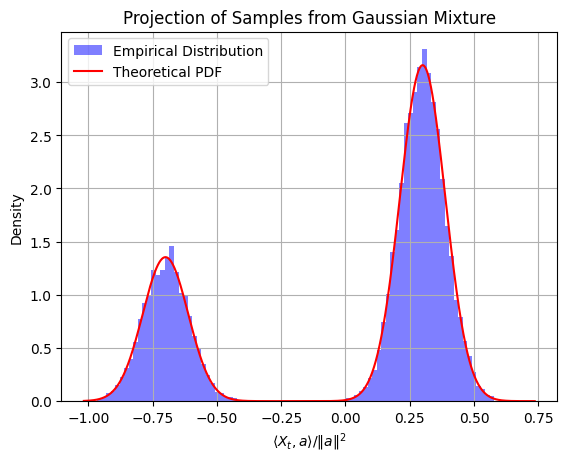

In [46]:
n = 128
p = 0.7
a = np.ones(n)
num_samples = 20000

mu1 = (1 - p) * a
mu2 = -p * a
cov = np.eye(n)

# Sample from the mixture model
components = np.random.choice([0, 1], size=num_samples, p=[p, 1 - p])
samples = np.array([
    multivariate_normal.rvs(mean=mu1 if c == 0 else mu2, cov=cov)
    for c in components
])

# Compute the projection ⟨X_t, a⟩ / ||a||²
a_norm_sq = np.linalg.norm(a) ** 2
projections = np.dot(samples, a) / a_norm_sq

# Plot histogram of projections
plt.hist(projections, bins = 100, density=True, alpha=0.5, color='blue', label="Empirical Distribution")

# Plot the theoretical density (red line)
x = np.linspace(min(projections), max(projections), 1000)
pdf = p * multivariate_normal.pdf(x, mean=(1-p), cov=1/n) + \
      (1 - p) * multivariate_normal.pdf(x, mean=-p, cov=1/n)

plt.plot(x, pdf, color='red', label="Theoretical PDF")
plt.xlabel(r'$\langle X_t, a \rangle / \|a\|^2$')
plt.ylabel('Density')
plt.title('Projection of Samples from Gaussian Mixture')
plt.legend()
plt.grid()
plt.show()

In [49]:
class TwoLayerDenoiser(nn.Module):
    def __init__(self, n, hidden_dim=256, L=3):
        super(TwoLayerDenoiser, self).__init__()
        self.lin0 = nn.Linear(42, L)                  # Time embedding φ → s
        self.lin1 = nn.Linear(n, hidden_dim)          # Input projection x → x1
        self.lin2 = nn.Linear(hidden_dim * L, n)      # Output projection

    def forward(self, x, alpha):
        batch_size = x.shape[0]
        alpha = alpha.unsqueeze(1)

        i_values = torch.arange(21, dtype=torch.float32, device=x.device)
        phi = torch.cat([torch.cos(alpha * i_values), torch.sin(alpha * i_values)], dim=1)

        s = self.lin0(phi)
        x1 = F.tanh(self.lin1(x)) #tanh

        outer_product = torch.einsum("bi,bj->bij", s, x1)  # Shape: (B, L, hidden_dim)
        x2 = outer_product.view(batch_size, -1)
        

        posterior_mean = torch.cos(alpha).pow(2) * (x + self.lin2(x2))
        return posterior_mean


In [50]:
denoiser = TwoLayerDenoiser(n)
training(denoiser, 
             samples,  
             num_epochs=500, 
             criterion = nn.MSELoss(), 
             lr=1e-3, 
             weight_decay=1e-4,
             alpha_max = np.pi/2-0.01)

Epoch [1/500] | Train Loss: 0.5398 | Val Loss: 60.5398% | 
Epoch [51/500] | Train Loss: 0.5252 | Val Loss: 59.7841% | 
Epoch [101/500] | Train Loss: 0.5249 | Val Loss: 60.3344% | 
Epoch [151/500] | Train Loss: 0.5272 | Val Loss: 60.1556% | 
Epoch [201/500] | Train Loss: 0.5340 | Val Loss: 59.7683% | 
Epoch [251/500] | Train Loss: 0.5319 | Val Loss: 60.0644% | 
Epoch [301/500] | Train Loss: 0.5282 | Val Loss: 59.8527% | 
Epoch [351/500] | Train Loss: 0.5311 | Val Loss: 59.5834% | 
Epoch [401/500] | Train Loss: 0.5289 | Val Loss: 60.1384% | 
Epoch [451/500] | Train Loss: 0.5296 | Val Loss: 59.9637% | 
Loaded best model with validation loss: 58.5920%


0

In [51]:
K = 200
alpha_it = torch.linspace(0, np.pi/2-0.2, K, dtype=torch.float32)
T = torch.tan(alpha_it[-1])**2
print(T)

num_samples_target = 5000
target_samples = torch.zeros(size=(num_samples_target, n), dtype = torch.float32)

y_curr = []
alpha_curr = []

for it in range(K-1):
        t = torch.tan(alpha_it[it])**2
      
        #print(t)
        delta_t = torch.tan(alpha_it[it+1])**2 - t
        
        alpha = alpha_it[it]
        #print(alpha, t, delta_t)
        alpha_vet = torch.full((num_samples_target,), alpha)
        scale =  1 
        #print(t,delta_t,alpha)

        if (it+1)%20 == 0:
              y_curr.append(target_samples)
              alpha_curr.append(alpha)
              print(alpha, t)

        noise = torch.randn((num_samples_target, n), dtype=torch.float32)
        drift = denoiser(target_samples,alpha_vet )
        target_samples = target_samples + delta_t*drift + torch.sqrt(torch.tensor(delta_t)) * noise
        

target_samples=target_samples/T #denoiser(target_samples, torch.full((num_samples_target,), alpha_it[-1]))

tensor(24.3360)


/var/folders/2c/01bhfspx2hj56fb5ryg654lr0000gn/T/ipykernel_93435/2502730744.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_samples = target_samples + delta_t*drift + torch.sqrt(torch.tensor(delta_t)) * noise


tensor(0.1309) tensor(0.0173)
tensor(0.2686) tensor(0.0758)
tensor(0.4064) tensor(0.1852)
tensor(0.5442) tensor(0.3662)
tensor(0.6820) tensor(0.6592)
tensor(0.8197) tensor(1.1473)
tensor(0.9575) tensor(2.0185)
tensor(1.0953) tensor(3.7711)
tensor(1.2330) tensor(8.1063)


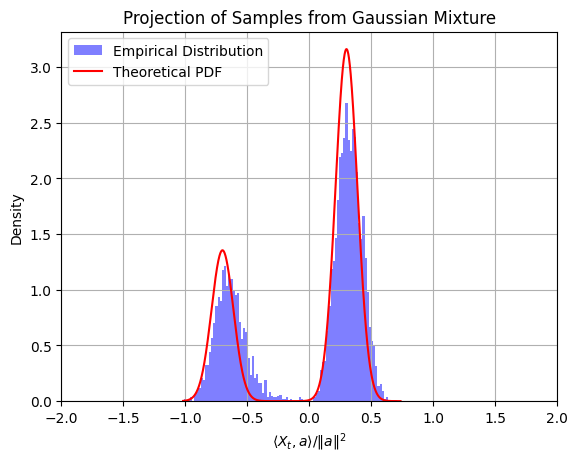

Projection mean: 0.0032400594808878426
Projection std: 0.4652080019454548


In [52]:
# Compute the projection ⟨X_t, a⟩ / ||a||²
projections_final= np.dot(target_samples.detach().numpy(), a) / a_norm_sq

# Plot histogram of projections
plt.hist(projections_final, bins = 100, density=True, alpha=0.5, color='blue', label="Empirical Distribution")
plt.xlim(-2, 2)  

plt.plot(x, pdf, color='red', label="Theoretical PDF")
plt.xlabel(r'$\langle X_t, a \rangle / \|a\|^2$')
plt.ylabel('Density')
plt.title('Projection of Samples from Gaussian Mixture')
plt.legend()
plt.grid()
plt.show()

print("Projection mean:", projections_final.mean())
print("Projection std:", projections_final.std())

In [53]:
def compute_posterior_mean_multidim_batch(y_t, t, mu1, mu2, w):
    """
    Compute E[X | y_t] for a batch of y_t vectors in R^n.
    
    Parameters:
    - y_t: np.array shape (batch_size, n)
    - mu1, mu2: np.array shape (n,)
    - w: scalar in (0,1)
    - t: scalar

    Returns:
    - posterior_mean: np.array shape (batch_size, n)
    """
    cov = t * (t + 1)

    # Ensure mu1 and mu2 are broadcastable
    mu1 = mu1.reshape(1, -1)  # shape: (1, n)
    mu2 = mu2.reshape(1, -1)

    delta1 = y_t - t * mu1  # shape: (batch_size, n)
    delta2 = y_t - t * mu2

    logp1 = -0.5 * np.sum(delta1**2, axis=1) / cov  # shape: (batch_size,)
    logp2 = -0.5 * np.sum(delta2**2, axis=1) / cov

    max_logp = np.maximum(logp1, logp2)
    p1 = w * np.exp(logp1 - max_logp)
    p2 = (1 - w) * np.exp(logp2 - max_logp)
    Z = p1 + p2

    gamma1 = (p1 / Z).reshape(-1, 1)  # shape: (batch_size, 1)
    gamma2 = (p2 / Z).reshape(-1, 1)

    # Posterior mean
    posterior_mean = (1 / (t + 1)) * y_t + (1 / (t + 1)) * (gamma1 * mu1 + gamma2 * mu2)
    return posterior_mean


/var/folders/2c/01bhfspx2hj56fb5ryg654lr0000gn/T/ipykernel_93435/3701847862.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples = torch.tensor(samples, dtype=torch.float32)


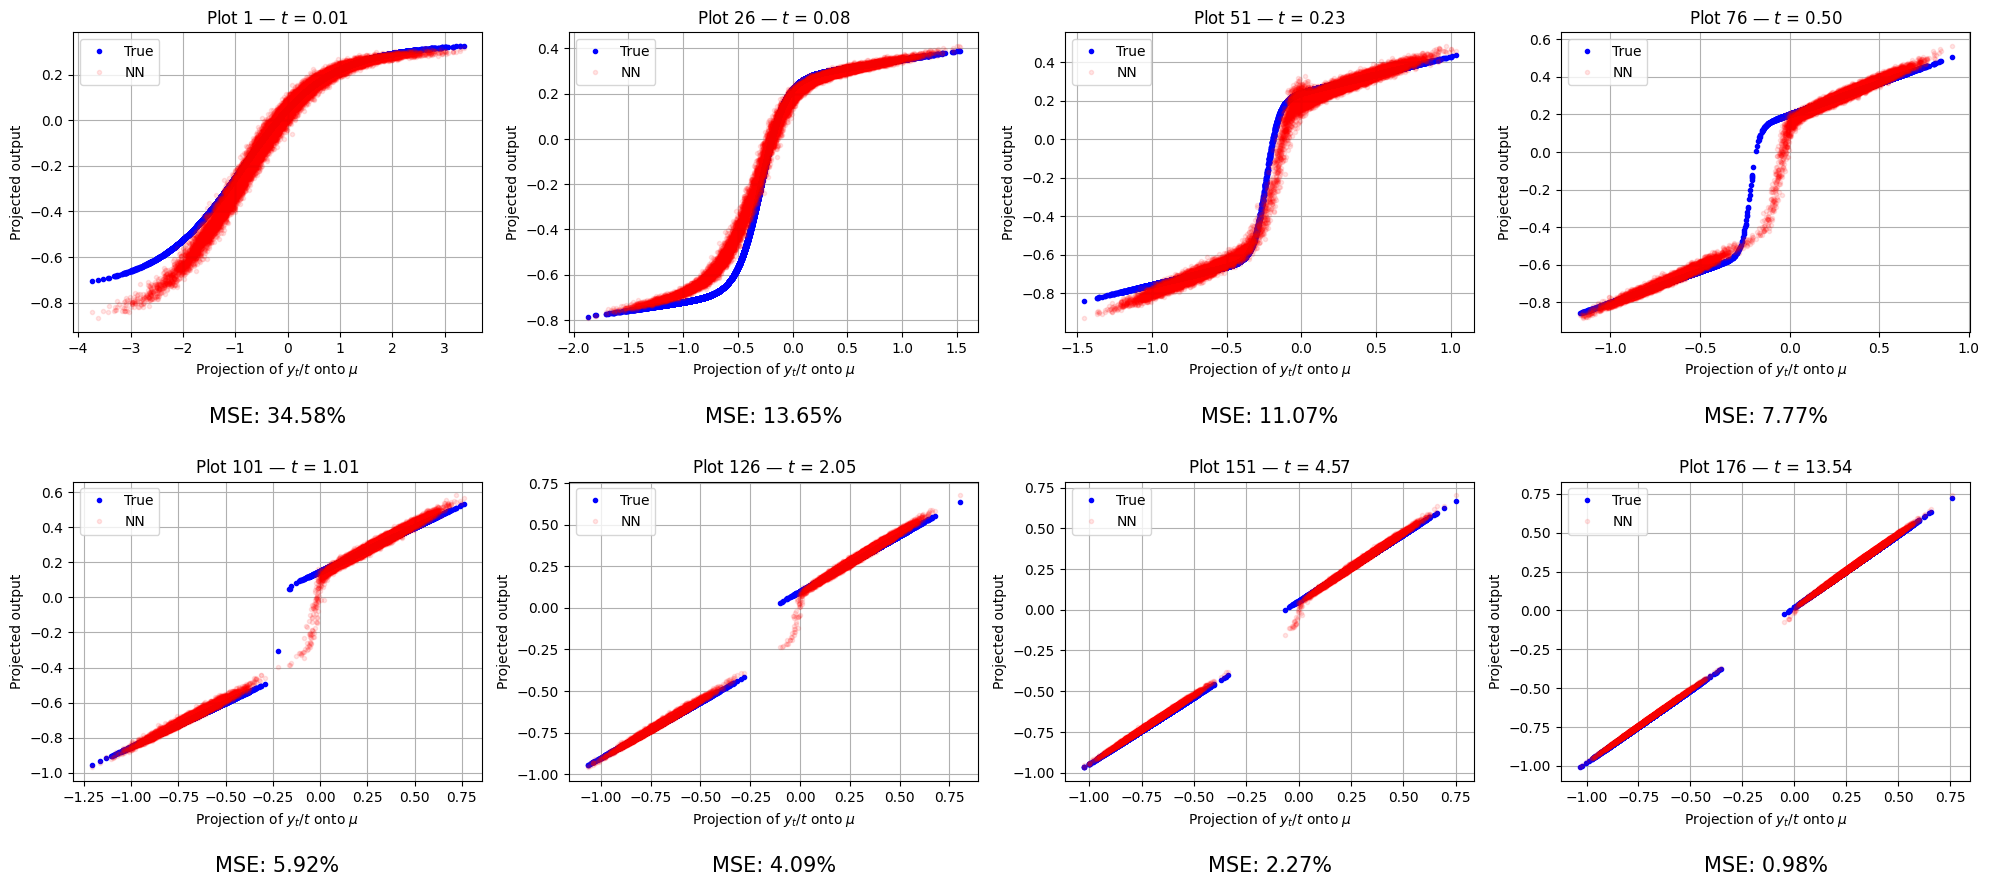

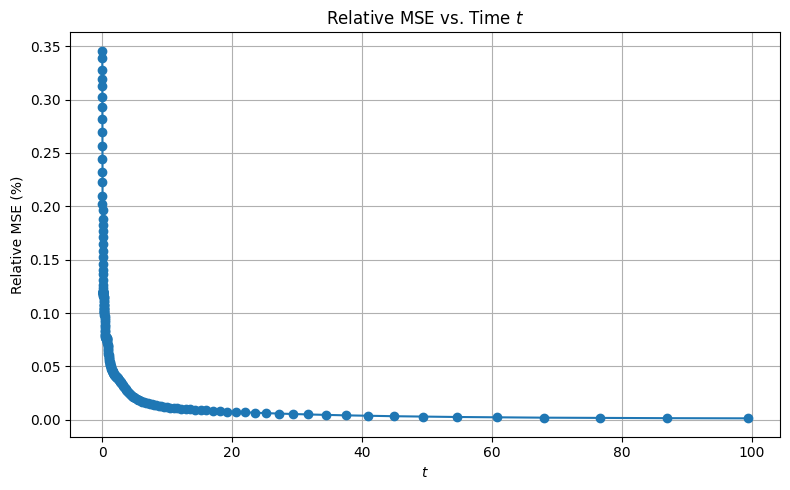

In [56]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import math

# Parameters
mu = a
a_norm_sq = np.linalg.norm(mu) ** 2
K = 200  # number of alpha values
num_samples = samples.shape[0]
alpha_grid = torch.linspace(0.1, np.pi / 2 - 0.1, K, dtype=torch.float32)

# Prepare grid for plots (1 every 20)
plot_every = 25
plot_indices = list(range(0, K, plot_every))
cols = 4
rows = math.ceil(len(plot_indices) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows))
axes = axes.flatten()

# Store errors
mse_list = []
t_list = []

# Prepare samples once
samples = torch.tensor(samples, dtype=torch.float32)

for i in range(K):
    alpha = alpha_grid[i]
    t = torch.tan(alpha).pow(2)
    t_np = t.detach().numpy()
    alpha_batch = torch.full((num_samples,), alpha)

    noise = torch.randn_like(samples)
    y_t = t * samples + t.sqrt() * noise
    y_np = y_t.detach().numpy()

    true_output = compute_posterior_mean_multidim_batch(y_np, t_np, mu1, mu2, p)
    nn_output = denoiser(y_t, alpha_batch).detach().numpy()

    rel_mse = np.sqrt(
        np.sum((nn_output - true_output) ** 2, axis=1) /
        np.clip(np.sum(true_output ** 2, axis=1), a_min=1e-8, a_max=None)
    )
    mse_list.append(rel_mse.mean().item())
    t_list.append(t_np)

    # Plot only every 20th
    if i in plot_indices:
        true_proj = np.dot(true_output, mu) / a_norm_sq
        nn_proj = np.dot(nn_output, mu) / a_norm_sq
        y_proj = (np.dot(y_np, mu) / a_norm_sq)/t

        ax = axes[plot_indices.index(i)]
        ax.plot(y_proj, true_proj, '.', color='blue', label='True')
        ax.plot(y_proj, nn_proj, '.', color='red', label='NN', alpha=0.1)
        ax.set_xlabel(r'Projection of $y_t/t$ onto $\mu$')
        ax.set_ylabel('Projected output')
        ax.set_title(f'Plot {i+1} — $t$ = {t:.2f}')
        ax.text(
            0.5, -0.25, f'MSE: {rel_mse.mean() * 100:.2f}%',
            transform=ax.transAxes, fontsize=15,
            ha='center', va='top'
        )
        ax.grid(True)
        ax.legend()

# Hide unused subplots
for j in range(len(plot_indices), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

# Plot MSE vs t
plt.figure(figsize=(8, 5))
plt.plot(t_list, mse_list, marker='o')
plt.xlabel(r'$t$')
plt.ylabel('Relative MSE (%)')
plt.title('Relative MSE vs. Time $t$')
plt.grid(True)
plt.tight_layout()
plt.show()


## variant with two denoisers

In [44]:
n = 128
p = 0.7
a = np.ones(n)
num_samples = 20000

mu1 = (1 - p) * a
mu2 = -p * a
cov = np.eye(n)

# Sample from the mixture model
components = np.random.choice([0, 1], size=num_samples, p=[p, 1 - p])
samples = np.array([
    multivariate_normal.rvs(mean=mu1 if c == 0 else mu2, cov=cov)
    for c in components
])

# Compute the projection ⟨X_t, a⟩ / ||a||²
a_norm_sq = np.linalg.norm(a) ** 2
projections = np.dot(samples, a) / a_norm_sq



# Plot the theoretical density (red line)
x = np.linspace(min(projections), max(projections), 1000)
pdf = p * multivariate_normal.pdf(x, mean=(1-p), cov=1/n) + \
      (1 - p) * multivariate_normal.pdf(x, mean=-p, cov=1/n)



C = np.cov(samples, rowvar=False)
# Compute the principal eigenvector using Lanczos (ARPACK)
eigvals, eigvecs = eigsh(C, k=1, which='LM')
principal_eigenvector = eigvecs[:, 0]

# Fix sign ambiguity by enforcing a consistent sign
if principal_eigenvector[np.argmax(np.abs(principal_eigenvector))] < 0:
    principal_eigenvector *= -1  # Flip the sign

# Compute the condition number (ratio of largest to smallest eigenvalue)
eigvals_full = np.linalg.eigvalsh(C)
condition_number = eigvals_full[-1] / eigvals_full[0]
print(condition_number)

samples_plus = samples[samples@principal_eigenvector>=0]
samples_minus = samples[samples@principal_eigenvector<0]
q = len(samples_plus)/num_samples
print(len(samples_plus), q)

denoiser_plus = TwoLayerDenoiser(n)
denoiser_minus = TwoLayerDenoiser(n)

32.8639452404942
14002 0.7001


# Training of denoiser_plus

In [45]:
denoiser_plus = TwoLayerDenoiser(n)
training(denoiser_plus, 
             samples_plus,  
             num_epochs=2000, 
             criterion = nn.MSELoss(), 
             lr=1e-3, 
             weight_decay=1e-4,
             alpha_max = np.pi/2-0.01)

Epoch [1/2000] | Train Loss: 0.5045 | Val Loss: 61.5223% | 


KeyboardInterrupt: 

# Training of denoiser_minus

In [ ]:
denoiser_minus = TwoLayerDenoiser(n)
training(denoiser_minus, 
             samples_minus,  
             num_epochs=2000, 
             criterion = nn.MSELoss(), 
             lr=1e-3, 
             weight_decay=1e-4,
             alpha_max = np.pi/2-0.01)

Epoch [1/2000] | Train Loss: 126.7563 | Val Loss: 62.7602% | 
Epoch [51/2000] | Train Loss: 0.5115 | Val Loss: 52.7468% | 
Epoch [101/2000] | Train Loss: 0.5137 | Val Loss: 52.6521% | 
Epoch [151/2000] | Train Loss: 0.5264 | Val Loss: 52.7230% | 
Epoch [201/2000] | Train Loss: 0.5025 | Val Loss: 52.8289% | 
Epoch [251/2000] | Train Loss: 0.5044 | Val Loss: 58.1567% | 
Epoch [301/2000] | Train Loss: 1.6760 | Val Loss: 52.1056% | 
Epoch [351/2000] | Train Loss: 0.5122 | Val Loss: 54.1712% | 
Epoch [401/2000] | Train Loss: 0.7497 | Val Loss: 52.7106% | 
Epoch [451/2000] | Train Loss: 0.5589 | Val Loss: 53.7412% | 
Epoch [501/2000] | Train Loss: 0.5309 | Val Loss: 52.4592% | 
Epoch [551/2000] | Train Loss: 0.5082 | Val Loss: 53.5870% | 
Epoch [601/2000] | Train Loss: 0.6641 | Val Loss: 53.2506% | 
Epoch [651/2000] | Train Loss: 0.4990 | Val Loss: 52.9175% | 
Epoch [701/2000] | Train Loss: 0.5122 | Val Loss: 53.9946% | 
Epoch [751/2000] | Train Loss: 2.1553 | Val Loss: 52.4915% | 
Epoch [80

0

# Diffusion with denoiser_plus

In [ ]:
K = 400
alpha_it = torch.linspace(0, np.pi/2-0.2, K, dtype=torch.float32)
T = torch.tan(alpha_it[-1])**2
print(T)

num_samples_target = int(np.floor(5000*q))
target_samples_plus = torch.zeros(size=(num_samples_target, n), dtype = torch.float32)


for it in range(K-1):
        t = torch.tan(alpha_it[it])**2
      
        #print(t)
        delta_t = torch.tan(alpha_it[it+1])**2 - t
        
        alpha = alpha_it[it]
        #print(alpha, t, delta_t)
        alpha_vet = torch.full((num_samples_target,), alpha)
        scale =  1 
        #print(t,delta_t,alpha)

        noise = torch.randn((num_samples_target, n), dtype=torch.float32)
        drift = denoiser_plus(target_samples_plus, alpha_vet )
        target_samples_plus = target_samples_plus + delta_t*drift + torch.sqrt(torch.tensor(delta_t)) * noise
        

target_samples_plus=target_samples_plus/T #denoiser(target_samples, torch.full((num_samples_target,), alpha_it[-1]))
print(target_samples_plus)

tensor(24.3360)


/var/folders/2c/01bhfspx2hj56fb5ryg654lr0000gn/T/ipykernel_900/4047415394.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_samples_plus = target_samples_plus + delta_t*drift + torch.sqrt(torch.tensor(delta_t)) * noise


tensor([[-2.1581, -0.9867,  0.4340,  ..., -0.2855,  1.6276, -3.0249],
        [ 1.5031, -0.1781,  1.1310,  ...,  1.1010, -0.2864,  1.9438],
        [ 0.2679,  0.0115,  0.8137,  ..., -0.8354, -0.5971, -0.4312],
        ...,
        [-0.3397,  0.1761, -0.3454,  ...,  1.1656, -0.0124, -0.5904],
        [-1.0735, -1.9234, -1.3350,  ...,  0.2556,  1.1038, -0.2741],
        [-0.8714, -0.4443,  0.8016,  ..., -0.1182, -2.7117,  0.1825]],
       grad_fn=<DivBackward0>)


# Diffusion with denoiser_minus

In [ ]:
K = 400
alpha_it = torch.linspace(0, np.pi/2-0.2, K, dtype=torch.float32)
T = torch.tan(alpha_it[-1])**2
print(T)

num_samples_target = int(np.floor(5000*(1-q)))
target_samples_minus = torch.zeros(size=(num_samples_target, n), dtype = torch.float32)


for it in range(K-1):
        t = torch.tan(alpha_it[it])**2
      
        #print(t)
        delta_t = torch.tan(alpha_it[it+1])**2 - t
        
        alpha = alpha_it[it]
        #print(alpha, t, delta_t)
        alpha_vet = torch.full((num_samples_target,), alpha)
        scale =  1 
        #print(t,delta_t,alpha)

        noise = torch.randn((num_samples_target, n), dtype=torch.float32)
        drift = denoiser_minus(target_samples_minus,alpha_vet )
        target_samples_minus = target_samples_minus + delta_t*drift + torch.sqrt(torch.tensor(delta_t)) * noise
        

target_samples_minus=target_samples_minus/T #denoiser(target_samples, torch.full((num_samples_target,), alpha_it[-1]))
print(target_samples_minus)

tensor(24.3360)


/var/folders/2c/01bhfspx2hj56fb5ryg654lr0000gn/T/ipykernel_900/438514904.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_samples_minus = target_samples_minus + delta_t*drift + torch.sqrt(torch.tensor(delta_t)) * noise


tensor([[-0.6635,  0.3484, -0.6233,  ..., -2.8522, -0.3436,  0.1186],
        [-0.4883, -0.2825, -0.0642,  ...,  0.2681, -1.7667, -1.0002],
        [-0.2792, -0.4408, -0.5837,  ..., -0.0793,  0.4356, -1.7479],
        ...,
        [-0.2738, -0.8281,  0.9604,  ...,  1.3229,  0.5193,  1.0896],
        [-1.2701, -1.0967, -1.4723,  ...,  0.1379, -0.7915, -0.3990],
        [-0.6208,  1.0407,  0.7006,  ..., -1.1874,  0.8192, -0.7558]],
       grad_fn=<DivBackward0>)


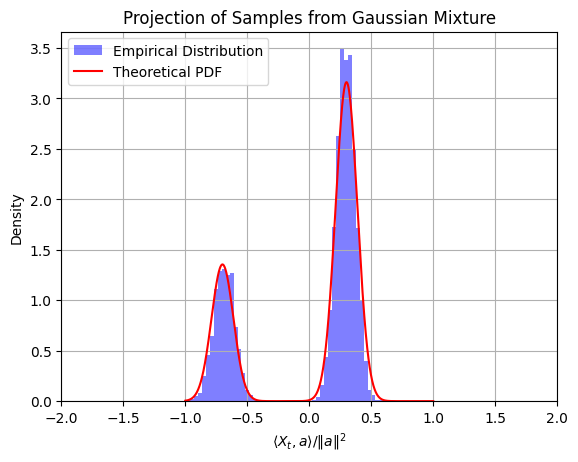

In [ ]:
target_samples = torch.cat((target_samples_minus,target_samples_plus))
# Compute the projection ⟨X_t, a⟩ / ||a||²
a_norm_sq = np.linalg.norm(a) ** 2
projections = np.dot(target_samples.detach().numpy(), a) / a_norm_sq

# Plot histogram of projections
plt.hist(projections, bins = 50, density=True, alpha=0.5, color='blue', label="Empirical Distribution")
plt.xlim(-2, 2)  

# Plot the theoretical density (red line)
x = np.linspace(-1, 1, 1000)
pdf = p * multivariate_normal.pdf(x, mean=(1-p), cov=1/n) + \
      (1 - p) * multivariate_normal.pdf(x, mean=-p, cov=1/n)

plt.plot(x, pdf, color='red', label="Theoretical PDF")
plt.xlabel(r'$\langle X_t, a \rangle / \|a\|^2$')
plt.ylabel('Density')
plt.title('Projection of Samples from Gaussian Mixture')
plt.legend()
plt.grid()
plt.show()